# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
from IPython.display import Image
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
#%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

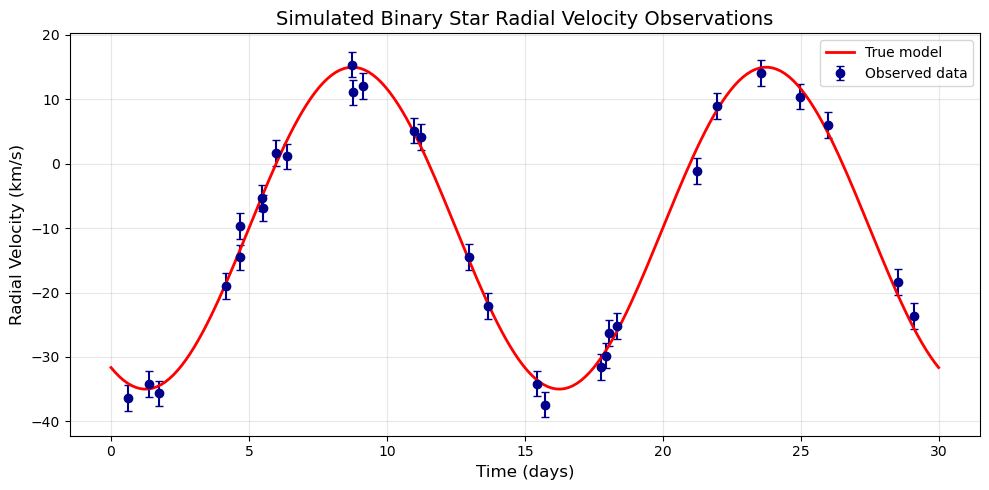

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [2]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [3]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    K, P, t0, v0 = theta
    rv_model = radial_velocity_model(t, K, P, t0, v0)
    return -0.5* np.sum((v - rv_model)**2 / v_err**2 + np.log(2 * np.pi * v_err**2)) #assuming Gaussian errors

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    K, P, t0, v0 = theta
    if 0 < K < 100 and 0 < P < 100 and 0 <= t0 <= P and -50 < v0 < 50:
        return 0 
    else:
        return -np.inf

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    return log_prior(theta) + log_likelihood(theta, t, v, v_err)

#### Justify the choice of prior in a few sentences

I chose the following constraints for the prior:
- 0 < K < 100. The velocity must be positive. 100 is mostly arbitrary- it is 4 times larger than the actual value and seemed like a reasonable limit.
- 0 < P < 100. The orbital period must be positive. 100 is once again mostly arbitary- it is 6.67 ties larger than the actual value and was a nice number that matched the K limit.
- 0 <= t0 <= P. The time of periastron passage must be less than the orbital period.   
- -50 < v0 < 50. The systemic velocity can be positive or negative. The -50 to 50 range is mostly arbitrary, but is equally likely to be positive or negative and matches the range of 100 for the K and P variables. 

#### Describe how you treated the uncertainties in a few sentences

The uncertainties were assumed to be Gaussian, and this is reflected in the `log_likelihood` function. The `(v - rv_model)` part calculate the residuals between the observed and predicted velocities. This is then divided by `v_err**2`, which downweights points with large uncertainties. Then, the `np.log(2 * np.pi * sigma2)` term is Gaussian and normalizes the function.

#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [4]:
# MCMC setup
from scipy.optimize import minimize

ndim = 4
nwalkers = 50 #used same numbers from lecture notes
nsteps = 15000
# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.
initial_guess = [25.0, 15.0, 5.0, -10.0] #choosing initial guess as actual values from earlier
min_guess = minimize(lambda theta: -log_likelihood(theta, t_obs, v_obs, v_err), initial_guess)
best_guess = min_guess.x
print(best_guess)

starting_guesses = best_guess + 0.0001*np.random.randn(nwalkers, ndim) #small random scatter around best guess

[ 24.65629709  15.15463097   4.94647136 -10.56684366]


#### Run the MCMC Sampler
This may take a minute or two.

In [5]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t_obs, v_obs, v_err))
# Run MCMC
_ =  sampler.run_mcmc(starting_guesses, nsteps, rstate0=np.random.get_state())
# Print the acceptance fraction from the sampler
acceptance_fraction = np.mean(sampler.acceptance_fraction)
print("Acceptance fraction:",acceptance_fraction)
print(sampler.acceptance_fraction)

Acceptance fraction: 0.594332
[0.5968     0.58946667 0.59793333 0.59713333 0.59626667 0.603
 0.59026667 0.59573333 0.59486667 0.5892     0.59653333 0.60093333
 0.59393333 0.5976     0.5908     0.59146667 0.59293333 0.5976
 0.60093333 0.58946667 0.58793333 0.5896     0.5934     0.59786667
 0.6012     0.59466667 0.5942     0.59726667 0.59413333 0.58966667
 0.5982     0.59826667 0.58846667 0.59373333 0.5934     0.58953333
 0.58633333 0.595      0.592      0.59146667 0.596      0.591
 0.58773333 0.60086667 0.59746667 0.5896     0.59706667 0.5958
 0.59993333 0.59193333]


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

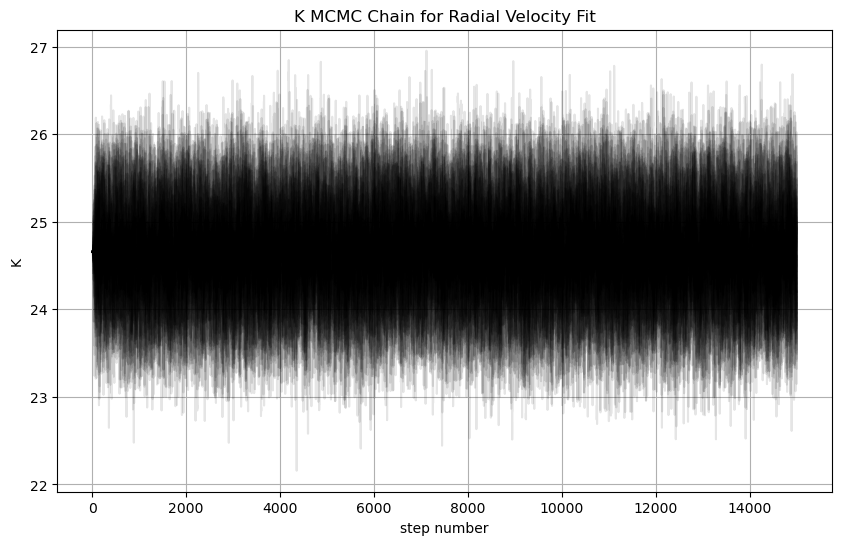

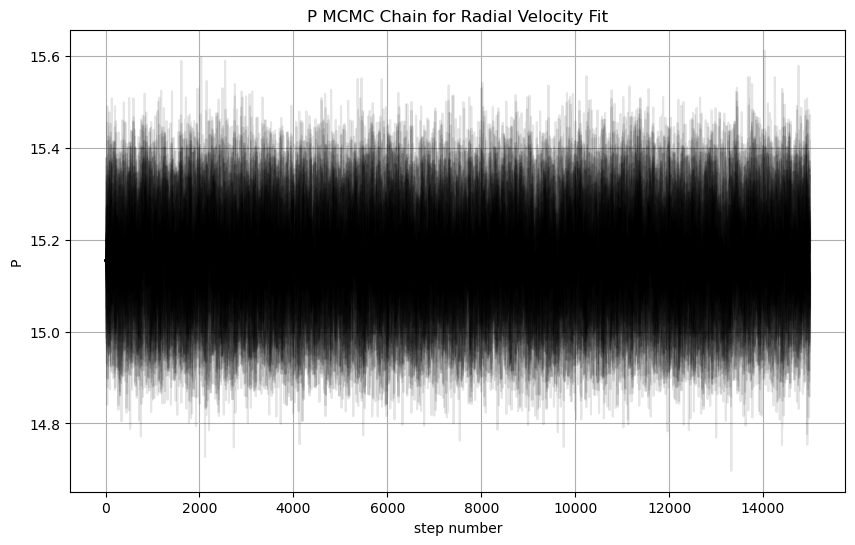

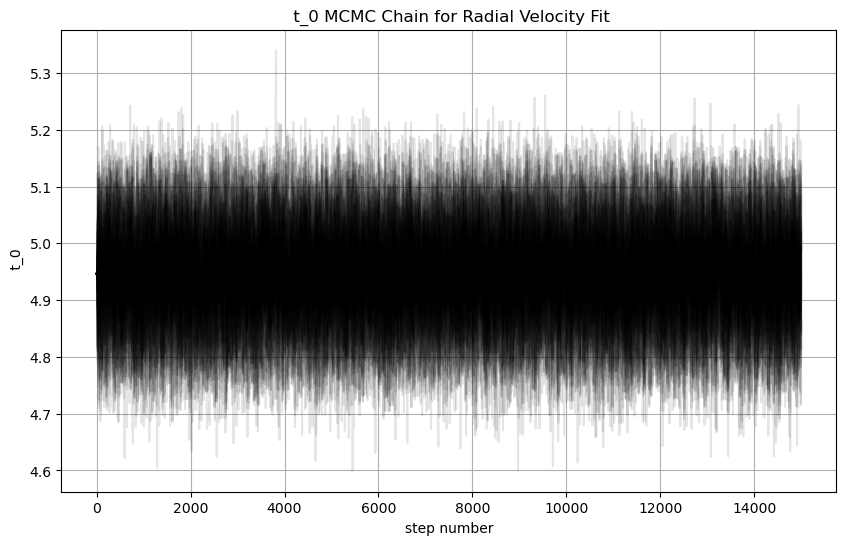

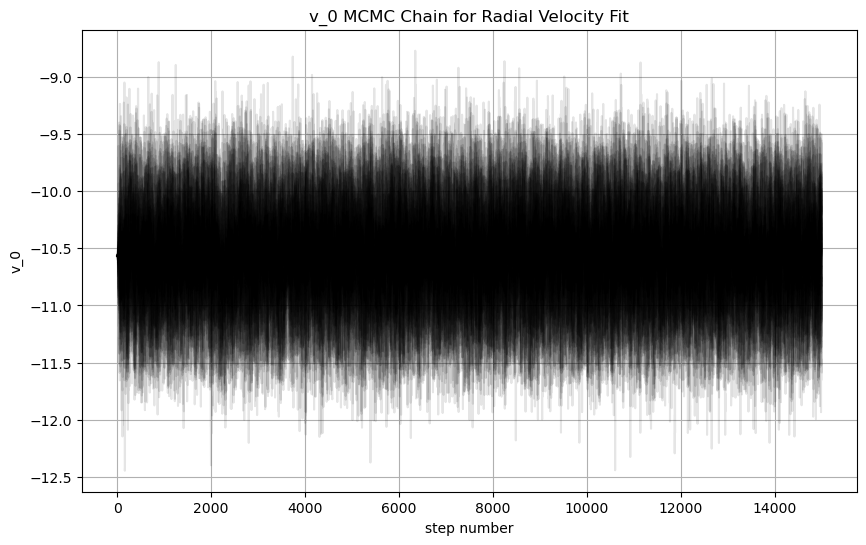

In [6]:
# Plot the chains - and remember to label your plots - you aren't silly first-years
import matplotlib.pyplot as plt

samples = sampler.get_chain()
ylabels = ["K", 'P', ' t_0', 'v_0']

for i in range(4):
    plt.figure(figsize = (10, 6))
    plt.plot(samples[:, :, i], color = 'black', alpha = 0.1)
    plt.title(f'{ylabels[i]} MCMC Chain for Radial Velocity Fit')
    plt.xlabel('step number')
    plt.ylabel(ylabels[i])
    plt.grid(True)
    plt.show()

In [7]:
#Autocorrelation times
autocorr_time = sampler.get_autocorr_time()
print(autocorr_time)

[44.46735711 48.90895664 47.68444007 46.42277536]


#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [8]:
# Get flattened samples (discard burn-in and thin)
burn_in = 2 * int(np.max(autocorr_time))
thinning = 2* int(np.min(autocorr_time))
flattened_samples = sampler.get_chain(discard=burn_in, thin=thinning, flat=True)
print(flattened_samples.shape)
# Calculate parameter estimates
param_names = ["K", "P", "t0", "v0"]
for i, name in enumerate(param_names):
    mean_val = np.mean(flattened_samples[:, i])
    std_val = np.std(flattened_samples[:, i])
    print(f'{param_names[i]} mean: {mean_val} +/- {std_val}')


(8450, 4)
K mean: 24.636482458703135 +/- 0.5214776519221073
P mean: 15.1553914411596 +/- 0.09777812579452794
t0 mean: 4.9455401784159 +/- 0.07658103461537837
v0 mean: -10.572791530219291 +/- 0.39881130628513833


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

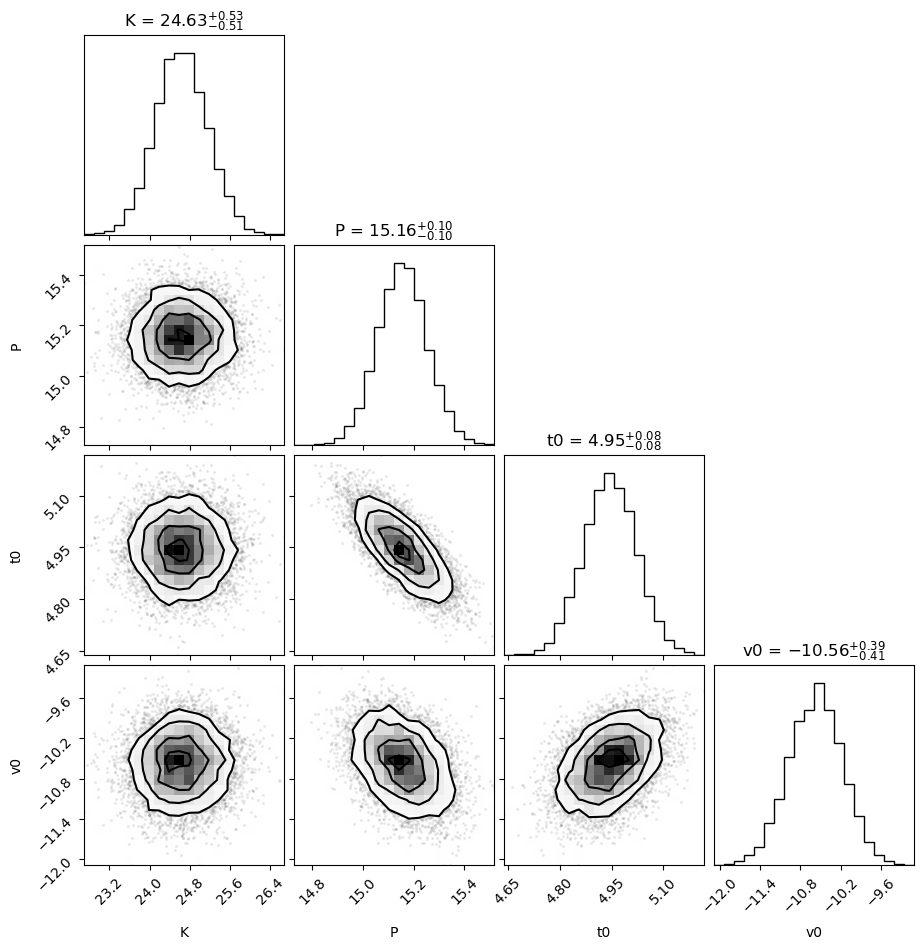

In [9]:
# you can use the corner package 
import corner

# Create the corner plot
fig = corner.corner(flattened_samples, labels=param_names, show_titles=True)
plt.show()

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

K median: 24.63265364808838
P median: 15.155343234698261
t0 median: 4.946309061876301
v0 median: -10.562439495672006


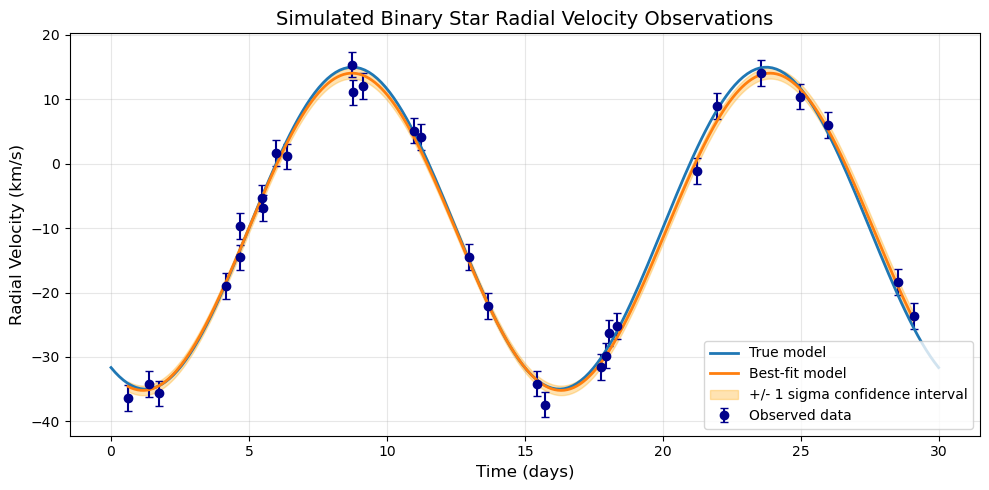

In [10]:
# also plot the true model - you can look at the simulation code
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, label='True model', linewidth=2)

#calcualte median values for best fit
med_vals = []
for i, name in enumerate(param_names):
    med_val = np.median(flattened_samples[:, i])
    med_vals.append(med_val)
    print(f'{param_names[i]} median: {med_val}')

#plot best fit model
t_best = np.linspace(np.min(t_obs), np.max(t_obs), 500)
v_best = radial_velocity_model(t_best, med_vals[0], med_vals[1], med_vals[2], med_vals[3])
plt.plot(t_best, v_best, label='Best-fit model', linewidth = 2)

#plot confidence interval (like lecture notes)
inds = np.random.choice(np.arange(0, len(flattened_samples)), 30)
v_vals = []
for i in inds:
    v_val = radial_velocity_model(t_best, flattened_samples[i, 0], flattened_samples[i, 1], flattened_samples[i, 2], flattened_samples[i, 3])
    v_vals.append(v_val)
v_stds = np.std(v_vals, axis = 0)
plt.fill_between(t_best, v_best - v_stds, v_best + v_stds, color='orange', alpha=0.3, label='+/- 1 sigma confidence interval')

#labeling and such
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

- P and t0 appear correlated, this is probably because they both affect the phase in the sine wave. P stretches/compreses the sine wave while t0 horizontally shifts the phase
- K and v0 don't appear correlated, but they might show slight correlation because if the mean velocity is misestimated, the amplitude can be increased to "compensate" and reach the points farther away from the upshifted or downshifted curve.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

From the final plot, it visually apepars that the MCMC analysis recovered the true parameters largely within the error bars. It loked like we found a good fit

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

(Graph below) By increasing the measurement uncertainty, the fit changes, and visually appears worse. The error bars on the observed data are also larger, causing the 1 sigma confidence interval to appear to better captures the data. This makes sense statistically because the model is much more flexible.

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?

If we used too few walkers, we might not fully explore the parameter space. Walkers can very easily get stuck in local minima/maxima, so making sure there are plenty of them ensures that those walkers are dominated by walkers that find the true minima/maxima. If we use too few steps, the walkers might still be in burn-in before they stop; they might not have ample time to converge. This leads to high uncertainty.

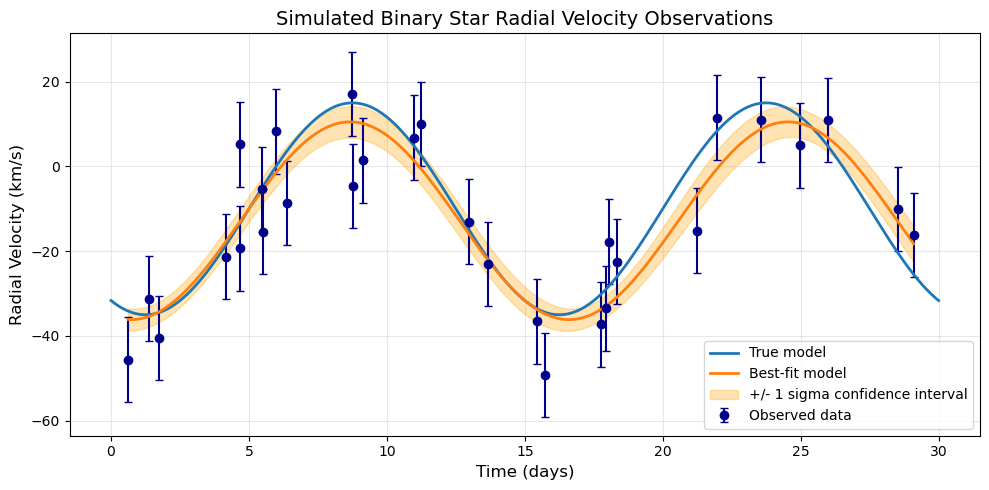

In [11]:
#v_err = 10.0 km/s graph
Image('/Users/veronicahoffman/Desktop/ASTR 496/images/output.png')